In [ ]:
#1) MOUNT THE GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#2) ACCESS THE DATASET

import os

address='/content/drive/MyDrive/datasets/PlantVillageMini'

#List Files
print(os.listdir(address))
num_classes=len(os.listdir(address))
print(num_classes)

count=0
for i in os.listdir(address):
  for j in os.listdir(os.path.join(address,i)):
    count+=1

print("Number of images:",count)

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']
5
Number of images: 4627


In [ ]:
#3) CREATING A TENSORFLOW DATASET USING THE IMAGES

#import os
import numpy as np
from sklearn.model_selection import train_test_split  #for train test split
from tensorflow.keras.utils import to_categorical #For one hot encoding

data_dir=address   #Root folder with class subfolders
class_names=os.listdir(data_dir)
num_classes=len(class_names)

#Collect file paths and labels
file_paths=[]
labels=[]

for class_id, class_name in enumerate(class_names):
  for image_name in os.listdir(os.path.join(address,class_name)):
    file_paths.append(os.path.join(address,class_name,image_name))
    labels.append(class_id)     #class_id is numerical 0,1,2,3,...

#Convert it into numpy arrays
file_paths=np.array(file_paths)
labels=np.array(labels)

print(file_paths.shape)
print(labels.shape)

#Train test split
X_train,X_test,y_train,y_test=train_test_split(file_paths,labels,test_size=0.2,random_state=42)

#one hot encoding
y_train=to_categorical(y_train,num_classes)
y_test=to_categorical(y_test,num_classes)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4627,)
(4627,)
(3701,)
(926,)
(3701, 5)
(926, 5)


In [ ]:
#4) LOADING AND PREPROCESSING THE IMAGES

import tensorflow as tf

print("Num GPU Available: ",len(tf.config.list_physical_devices('GPU')))

input_size=[224,224]

def preprocess_image(image_path, label):
  image=tf.io.read_file(image_path)
  image=tf.image.decode_jpeg(image, channels=3)   #read the jpeg image as color
  image=tf.image.resize(image, input_size)       #Resized the image to standard size
  image=image/255.0    #normalize the images
  return image,label

#Creating a tensorflow dataset
train_dataset=tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset=tf.data.Dataset.from_tensor_slices((X_test, y_test))

#apply preprocessing
train_dataset=train_dataset.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)   #batches of 32, with prefetch optimization for faster load
test_dataset=test_dataset.map(preprocess_image).batch(32)

Num GPU Available:  0


In [ ]:
#5) LOADING THE PREPROCESSED MODEL

from tensorflow.keras import layers, models

#load the MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,    #Removing the last layer
    weights='imagenet'    #load weights trained on imagenet
)

#freeze the base model
base_model.trainable=False    #weights of original model will not change

#adding our custom classification layer
model=models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),    #reduces feature map to a vector
    layers.Dense(128, activation="relu"),   #extra dense layer for better training
    layers.Dense(num_classes, activation="softmax")
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
#6) COMPILE THE MODEL

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS=10
early_stop=EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')   #stop training early if accuracy starts to reduce
reduce_lr=ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

model.fit(train_dataset, validation_data=test_dataset, epochs=EPOCHS, callbacks=[early_stop,reduce_lr])

Epoch 1/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 621s 5s/step - accuracy: 0.8135 - loss: 0.5158 - val_accuracy: 0.9719 - val_loss: 0.0735 - learning_rate: 0.0010
Epoch 2/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.9712 - loss: 0.0821 - val_accuracy: 0.9795 - val_loss: 0.0562 - learning_rate: 0.0010
Epoch 3/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.9908 - loss: 0.0391 - val_accuracy: 0.9806 - val_loss: 0.0444 - learning_rate: 0.0010
Epoch 4/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9960 - loss: 0.0249 - val_accuracy: 0.9784 - val_loss: 0.0544 - learning_rate: 0.0010
Epoch 5/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9963 - loss: 0.0201
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
116/116 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.9962 - loss: 0.0201 - val_accuracy: 0.9752 - val_loss: 0.0708 - learning_rate: 0.0010
Epoch 6/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9976 - loss: 0.016

In [ ]:
#Testing for accuracy
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

29/29 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9846 - loss: 0.0480
Test Loss: 0.04067780077457428
Test Accuracy: 98.81%


In [ ]:
#Making Predictions
import matplotlib.pyplot as plt

for images, labels in test_dataset.take(1):
    # images.shape => (batch_size, height, width, channels)
    # labels.shape => (batch_size,)

    # 2. Take first 5 images
    five_images = images[:5]
    five_labels = labels[:5]
    break  # Only need one batch

predictions = model.predict(five_images)
predicted_classes = tf.argmax(predictions, axis=1)

print("Predicted classes:", predicted_classes.numpy())
print("True labels:", five_labels.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted classes: [2 1 1 2 0]
True labels: [[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


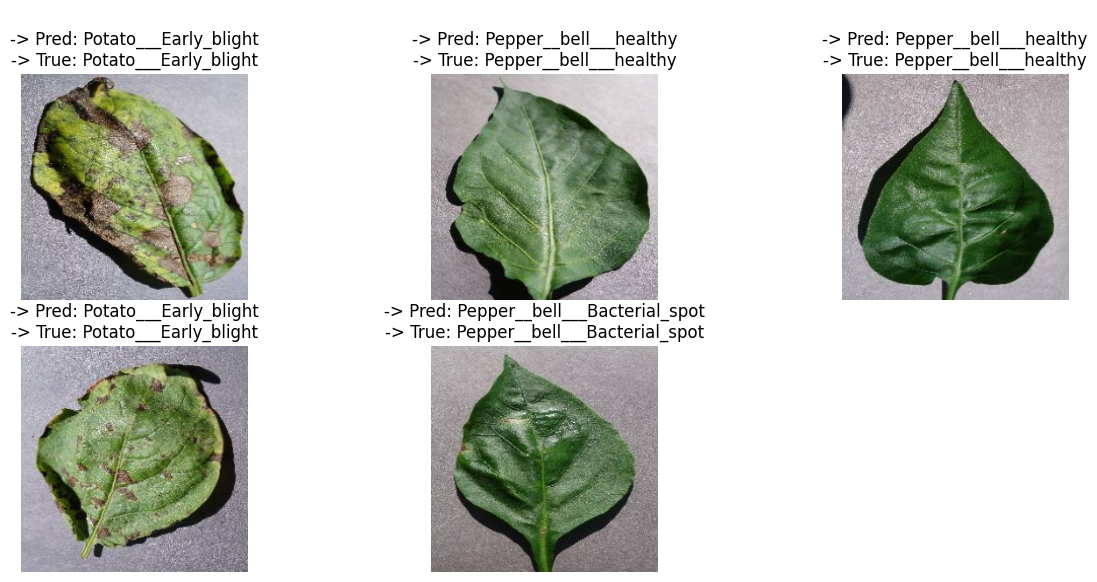

In [ ]:
import matplotlib.pyplot as plt

class_names = os.listdir(data_dir)

plt.figure(figsize=(15,10))
for i in range(5):
    plt.subplot(3,3,i+1)
    plt.imshow(five_images[i])
    plt.title("\n-> Pred: "+class_names[predicted_classes[i]]+"\n-> True: "+class_names[np.argmax(five_labels[i])])
    plt.axis('off')
plt.show()

In [ ]:
model.save("LeafClassifier_MobileNet1.keras")
from google.colab import files
files.download('LeafClassifier_MobileNet1.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>